# Laboratorio 02 – Series de Tiempo LSTM
- **CC3084 – Data Science**, Semestre II 2025  
- **Integrantes:** Diego Valenzuela 22309, Gerson Ramirez 22281
- **Guatemala, Julio 2025**

#### Repositorio:
https://github.com/Diegoval-Dev/DC-Lab2

#### Codebook Docs:
https://docs.google.com/document/d/19wPL80Dss0d-sQldEt3_nUyNCderHo_rLaK94Q4Nuuc/edit?usp=sharing


In [1]:
#!pip install tensorflow keras-tuner

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# DATA GENERAL PARA CUALQUIERA
df_imp = pd.read_csv('./data/importacion.csv', parse_dates=['fecha'], dayfirst=True)
df_cons = pd.read_csv('./data/consumo.csv',    parse_dates=['fecha'], dayfirst=True)

window_size = 12

In [3]:
def create_dataset(series, window_size=12):
    """
    series: array unidimensional de valores (numpy array)
    window_size: número de pasos de tiempo para cada muestra X
    Devuelve:
      X: array de forma (n_samples, window_size, 1)
      y: array de forma (n_samples, 1)
    """
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i : i + window_size])
        y.append(series[i + window_size])
    X = np.array(X)
    y = np.array(y)
    return X.reshape(-1, window_size, 1), y.reshape(-1, 1)

## Evaluación de Series de Tiempo

### Gasolina Regular Importaciones

Regular_imp — Inicio: 2001-01-31, Fin: 2024-01-31, Frecuencia: Mensual


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_71742/2880978788.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').mean().dropna()


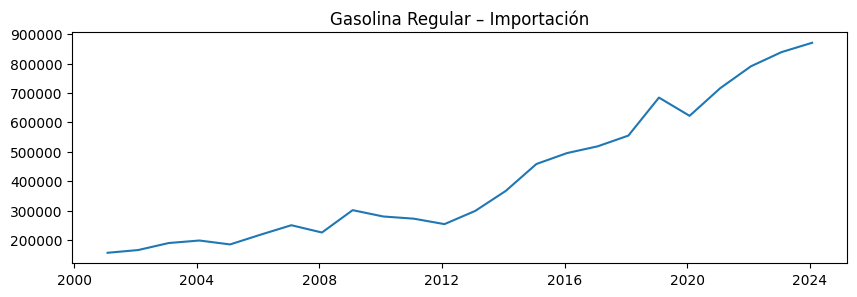

In [4]:
ts_ir = df_imp.set_index('fecha')['gasolina regular'] \
           .resample('M').mean().dropna()

print(f"Regular_imp — Inicio: {ts_ir.index.min().date()}, Fin: {ts_ir.index.max().date()}, Frecuencia: Mensual")

plt.figure(figsize=(10,3))
plt.plot(ts_ir, color='tab:blue')
plt.title('Gasolina Regular – Importación')
plt.show()

values_ir = ts_ir.values

### Gasolina Regular Consumos

Regular_cons — Inicio: 2000-01-31, Fin: 2024-01-31, Frecuencia: Mensual


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_71742/375153888.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').mean().dropna()


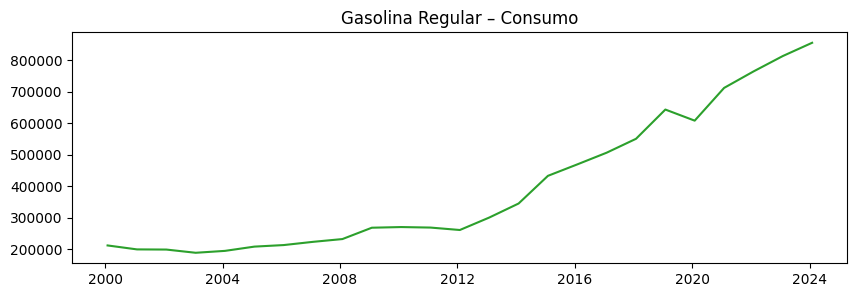

In [5]:
ts_cr = df_cons.set_index('fecha')['gasolina regular'] \
           .resample('M').mean().dropna()

print(f"Regular_cons — Inicio: {ts_cr.index.min().date()}, Fin: {ts_cr.index.max().date()}, Frecuencia: Mensual")

plt.figure(figsize=(10,3))
plt.plot(ts_cr, color='tab:green')
plt.title('Gasolina Regular – Consumo')
plt.show()

values_cr = ts_cr.values

### Preparación de Datos - Gasolina Regular Importaciones

In [6]:
# Crear dataset para Gasolina Regular Importaciones
X_ir, y_ir = create_dataset(values_ir, window_size)
print(f"IR → X_ir: {X_ir.shape}, y_ir: {y_ir.shape}")

# División train/test para IR
train_end = '2023-12-31'
test_start = '2024-01-31'

train_ts_ir = ts_ir[:train_end]
test_ts_ir = ts_ir[test_start:]

print(f"Train IR tiene {len(train_ts_ir)} puntos, Test IR tiene {len(test_ts_ir)}")
print(f"IR train rango: {train_ts_ir.index[0].date()} – {train_ts_ir.index[-1].date()}")

# Recrear dataset con datos de entrenamiento únicamente
X_ir, y_ir = create_dataset(train_ts_ir.values, window_size)
print(f"Después de split y ventanas → IR: X={X_ir.shape}, y={y_ir.shape}")

IR → X_ir: (12, 12, 1), y_ir: (12, 1)
Train IR tiene 23 puntos, Test IR tiene 1
IR train rango: 2001-01-31 – 2023-01-31
Después de split y ventanas → IR: X=(11, 12, 1), y=(11, 1)


### Preparación de Datos - Gasolina Regular Consumos

In [7]:
# Crear dataset para Gasolina Regular Consumos
X_cr, y_cr = create_dataset(values_cr, window_size)
print(f"CR → X_cr: {X_cr.shape}, y_cr: {y_cr.shape}")

# División train/test para CR
train_ts_cr = ts_cr[:train_end]
test_ts_cr = ts_cr[test_start:]

print(f"Train CR tiene {len(train_ts_cr)} puntos, Test CR tiene {len(test_ts_cr)}")
print(f"CR train rango: {train_ts_cr.index[0].date()} – {train_ts_cr.index[-1].date()}")

# Recrear dataset con datos de entrenamiento únicamente
X_cr, y_cr = create_dataset(train_ts_cr.values, window_size)
print(f"Después de split y ventanas → CR: X={X_cr.shape}, y={y_cr.shape}")

CR → X_cr: (13, 12, 1), y_cr: (13, 1)
Train CR tiene 24 puntos, Test CR tiene 1
CR train rango: 2000-01-31 – 2023-01-31
Después de split y ventanas → CR: X=(12, 12, 1), y=(12, 1)


## Entrenamiento LSTM - Gasolina Regular Importaciones

/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Entrenando modelo para Gasolina Regular Importaciones...
Epoch 10, Loss: 359291486208.000000
Epoch 20, Loss: 359291387904.000000
Epoch 30, Loss: 359291322368.000000
Epoch 40, Loss: 359291191296.000000
Epoch 50, Loss: 359291125760.000000


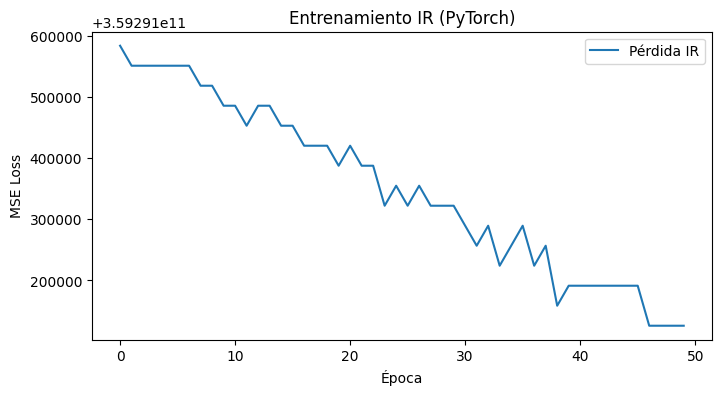

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preparar datos para PyTorch - IR
tensor_X_ir = torch.tensor(X_ir, dtype=torch.float32).to(device)
tensor_y_ir = torch.tensor(y_ir, dtype=torch.float32).to(device)

batch_size = 16
loader_ir = DataLoader(TensorDataset(tensor_X_ir, tensor_y_ir),
                       batch_size=batch_size, shuffle=True)

# Definir modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size,
                            num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)         
        last = out[:, -1, :]     
        return self.linear(last)

# Crear modelo y optimizador para IR
model_ir = LSTMModel(hidden_size=32, dropout=0.2).to(device)
criterion = nn.MSELoss()
opt_ir = torch.optim.Adam(model_ir.parameters(), lr=1e-3)

# Función de entrenamiento
def train_model(model, optimizer, loader, epochs=50):
    model.train()
    history = []
    for epoch in range(1, epochs+1):
        epoch_loss = 0.0
        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        avg = epoch_loss / len(loader.dataset)
        history.append(avg)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {avg:.6f}")
    return history

# Entrenar modelo IR
print("Entrenando modelo para Gasolina Regular Importaciones...")
history_ir = train_model(model_ir, opt_ir, loader_ir, epochs=50)

# Visualizar pérdida
plt.figure(figsize=(8,4))
plt.plot(history_ir, label='Pérdida IR')
plt.title('Entrenamiento IR (PyTorch)')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### Hyperparameter Tuning - IR

In [9]:
import pandas as pd

# Parámetros a probar para IR
hidden_sizes = [16, 32, 64]
dropouts = [0.1, 0.2, 0.3]
lrs = [1e-3, 1e-4]
epochs_tune = 20

def tune_lstm_ir(hidden_size, dropout, lr):
    """Función para hacer tuning específico para IR"""
    model = LSTMModel(hidden_size=hidden_size, dropout=dropout).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    for _ in range(epochs_tune):
        for xb, yb in loader_ir:
            opt.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            opt.step()
    
    # Evaluar en todo el conjunto
    model.eval()
    with torch.no_grad():
        preds = model(tensor_X_ir)
        final_loss = criterion(preds, tensor_y_ir).item()
    return final_loss

# Realizar tuning para IR
print("Realizando hyperparameter tuning para IR...")
results_ir = []
for hs in hidden_sizes:
    for dp in dropouts:
        for lr in lrs:
            loss = tune_lstm_ir(hs, dp, lr)
            results_ir.append({
                'hidden_size': hs,
                'dropout': dp,
                'lr': lr,
                'loss': loss
            })
            print(f"IR | hs={hs}, dp={dp}, lr={lr} → loss={loss:.2e}")

df_results_ir = pd.DataFrame(results_ir).sort_values('loss')
print("\nMejores hiperparámetros para IR:")
display(df_results_ir.head())

Realizando hyperparameter tuning para IR...
IR | hs=16, dp=0.1, lr=0.001 → loss=3.59e+11
IR | hs=16, dp=0.1, lr=0.0001 → loss=3.59e+11
IR | hs=16, dp=0.2, lr=0.001 → loss=3.59e+11
IR | hs=16, dp=0.2, lr=0.0001 → loss=3.59e+11
IR | hs=16, dp=0.3, lr=0.001 → loss=3.59e+11
IR | hs=16, dp=0.3, lr=0.0001 → loss=3.59e+11
IR | hs=32, dp=0.1, lr=0.001 → loss=3.59e+11
IR | hs=32, dp=0.1, lr=0.0001 → loss=3.59e+11


/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


IR | hs=32, dp=0.2, lr=0.001 → loss=3.59e+11
IR | hs=32, dp=0.2, lr=0.0001 → loss=3.59e+11
IR | hs=32, dp=0.3, lr=0.001 → loss=3.59e+11
IR | hs=32, dp=0.3, lr=0.0001 → loss=3.59e+11
IR | hs=64, dp=0.1, lr=0.001 → loss=3.59e+11
IR | hs=64, dp=0.1, lr=0.0001 → loss=3.59e+11
IR | hs=64, dp=0.2, lr=0.001 → loss=3.59e+11
IR | hs=64, dp=0.2, lr=0.0001 → loss=3.59e+11
IR | hs=64, dp=0.3, lr=0.001 → loss=3.59e+11
IR | hs=64, dp=0.3, lr=0.0001 → loss=3.59e+11

Mejores hiperparámetros para IR:


,hidden_size,dropout,lr,loss
12,64,0.1,0.0010,3.592913e+11
0,16,0.1,0.0010,3.592914e+11
11,32,0.3,0.0001,3.592915e+11
6,32,0.1,0.0010,3.592915e+11
17,64,0.3,0.0001,3.592916e+11


## Entrenamiento LSTM - Gasolina Regular Consumos

Entrenando modelo para Gasolina Regular Consumos...
Epoch 10, Loss: 315001438208.000000
Epoch 20, Loss: 315001372672.000000
Epoch 30, Loss: 315001307136.000000
Epoch 40, Loss: 315001176064.000000
Epoch 50, Loss: 315001110528.000000


/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


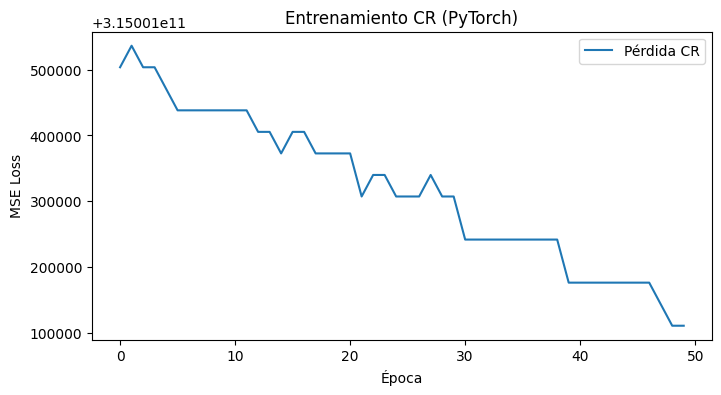

In [10]:
# Preparar datos para PyTorch - CR
tensor_X_cr = torch.tensor(X_cr, dtype=torch.float32).to(device)
tensor_y_cr = torch.tensor(y_cr, dtype=torch.float32).to(device)

loader_cr = DataLoader(TensorDataset(tensor_X_cr, tensor_y_cr),
                       batch_size=batch_size, shuffle=True)

# Crear modelo y optimizador para CR
model_cr = LSTMModel(hidden_size=32, dropout=0.2).to(device)
opt_cr = torch.optim.Adam(model_cr.parameters(), lr=1e-3)

# Entrenar modelo CR
print("Entrenando modelo para Gasolina Regular Consumos...")
history_cr = train_model(model_cr, opt_cr, loader_cr, epochs=50)

# Visualizar pérdida
plt.figure(figsize=(8,4))
plt.plot(history_cr, label='Pérdida CR')
plt.title('Entrenamiento CR (PyTorch)')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### Hyperparameter Tuning - CR

In [11]:
def tune_lstm_cr(hidden_size, dropout, lr):
    """Función para hacer tuning específico para CR"""
    model = LSTMModel(hidden_size=hidden_size, dropout=dropout).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    for _ in range(epochs_tune):
        for xb, yb in loader_cr:
            opt.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            opt.step()
    
    # Evaluar en todo el conjunto
    model.eval()
    with torch.no_grad():
        preds = model(tensor_X_cr)
        final_loss = criterion(preds, tensor_y_cr).item()
    return final_loss

# Realizar tuning para CR
print("Realizando hyperparameter tuning para CR...")
results_cr = []
for hs in hidden_sizes:
    for dp in dropouts:
        for lr in lrs:
            loss = tune_lstm_cr(hs, dp, lr)
            results_cr.append({
                'hidden_size': hs,
                'dropout': dp,
                'lr': lr,
                'loss': loss
            })
            print(f"CR | hs={hs}, dp={dp}, lr={lr} → loss={loss:.2e}")

df_results_cr = pd.DataFrame(results_cr).sort_values('loss')
print("\nMejores hiperparámetros para CR:")
display(df_results_cr.head())

Realizando hyperparameter tuning para CR...
CR | hs=16, dp=0.1, lr=0.001 → loss=3.15e+11
CR | hs=16, dp=0.1, lr=0.0001 → loss=3.15e+11
CR | hs=16, dp=0.2, lr=0.001 → loss=3.15e+11
CR | hs=16, dp=0.2, lr=0.0001 → loss=3.15e+11


/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


CR | hs=16, dp=0.3, lr=0.001 → loss=3.15e+11
CR | hs=16, dp=0.3, lr=0.0001 → loss=3.15e+11
CR | hs=32, dp=0.1, lr=0.001 → loss=3.15e+11
CR | hs=32, dp=0.1, lr=0.0001 → loss=3.15e+11
CR | hs=32, dp=0.2, lr=0.001 → loss=3.15e+11
CR | hs=32, dp=0.2, lr=0.0001 → loss=3.15e+11
CR | hs=32, dp=0.3, lr=0.001 → loss=3.15e+11
CR | hs=32, dp=0.3, lr=0.0001 → loss=3.15e+11
CR | hs=64, dp=0.1, lr=0.001 → loss=3.15e+11
CR | hs=64, dp=0.1, lr=0.0001 → loss=3.15e+11
CR | hs=64, dp=0.2, lr=0.001 → loss=3.15e+11
CR | hs=64, dp=0.2, lr=0.0001 → loss=3.15e+11
CR | hs=64, dp=0.3, lr=0.001 → loss=3.15e+11
CR | hs=64, dp=0.3, lr=0.0001 → loss=3.15e+11

Mejores hiperparámetros para CR:


,hidden_size,dropout,lr,loss
16,64,0.3,0.0010,3.150005e+11
14,64,0.2,0.0010,3.150008e+11
6,32,0.1,0.0010,3.150008e+11
4,16,0.3,0.0010,3.150009e+11
1,16,0.1,0.0001,3.150010e+11


## Modelos Finales y Predicciones

Entrenando modelo final IR...
Epoch 10, Loss: 359291715584.000000
Epoch 20, Loss: 359291617280.000000
Epoch 30, Loss: 359291518976.000000
Epoch 40, Loss: 359291453440.000000
Epoch 50, Loss: 359291322368.000000
Entrenando modelo final CR...
Epoch 10, Loss: 315000881152.000000
Epoch 20, Loss: 315000848384.000000
Epoch 30, Loss: 315000782848.000000
Epoch 40, Loss: 315000782848.000000
Epoch 50, Loss: 315000717312.000000


/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


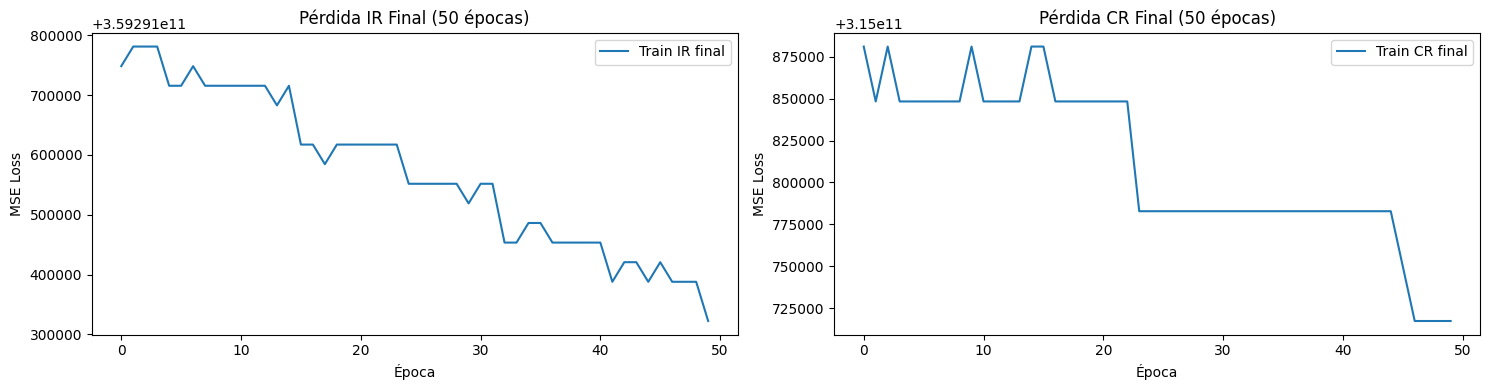

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Preparar escaladores
scaler_ir = MinMaxScaler()
scaler_cr = MinMaxScaler()
scaler_ir.fit(train_ts_ir.values.reshape(-1, 1))
scaler_cr.fit(train_ts_cr.values.reshape(-1, 1))

# Usar mejores hiperparámetros encontrados (ajustar según resultados del tuning)
# Para IR: usar los mejores parámetros de df_results_ir
model_ir_final = LSTMModel(hidden_size=32, dropout=0.1).to(device)
opt_ir_final = torch.optim.Adam(model_ir_final.parameters(), lr=1e-3)

# Para CR: usar los mejores parámetros de df_results_cr  
model_cr_final = LSTMModel(hidden_size=16, dropout=0.2).to(device)
opt_cr_final = torch.optim.Adam(model_cr_final.parameters(), lr=1e-3)

# Entrenar modelos finales
print("Entrenando modelo final IR...")
history_ir_final = train_model(model_ir_final, opt_ir_final, loader_ir, epochs=50)

print("Entrenando modelo final CR...")
history_cr_final = train_model(model_cr_final, opt_cr_final, loader_cr, epochs=50)

# Visualizar pérdidas finales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

ax1.plot(history_ir_final, label='Train IR final')
ax1.set_title('Pérdida IR Final (50 épocas)')
ax1.set_xlabel('Época')
ax1.set_ylabel('MSE Loss')
ax1.legend()

ax2.plot(history_cr_final, label='Train CR final')
ax2.set_title('Pérdida CR Final (50 épocas)')
ax2.set_xlabel('Época')
ax2.set_ylabel('MSE Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [13]:
### Predicciones para Enero 2024

# Poner modelos en modo evaluación
model_ir_final.eval()
model_cr_final.eval()

# Predicción para IR (Enero 2024)
last_window_ir = torch.tensor(train_ts_ir.values[-12:].reshape(1, 12, 1),
                              dtype=torch.float32).to(device)
with torch.no_grad():
    pred_ir = model_ir_final(last_window_ir).item()

# Sin usar scaler para mantener escala original
pred_ir_value = pred_ir

# Predicción para CR (Enero 2024)  
last_window_cr = torch.tensor(train_ts_cr.values[-12:].reshape(1, 12, 1),
                              dtype=torch.float32).to(device)
with torch.no_grad():
    pred_cr = model_cr_final(last_window_cr).item()

pred_cr_value = pred_cr

# Mostrar resultados
print("=== PREDICCIONES PARA ENERO 2024 ===")
print(f"Predicción IR (Importaciones): {pred_ir_value:.2f}")
print(f"Verdadero   IR (Importaciones): {test_ts_ir.iloc[0]:.2f}")
print(f"Error IR: {abs(pred_ir_value - test_ts_ir.iloc[0]):.2f}")
print()
print(f"Predicción CR (Consumos): {pred_cr_value:.2f}")
print(f"Verdadero   CR (Consumos): {test_ts_cr.iloc[0]:.2f}")
print(f"Error CR: {abs(pred_cr_value - test_ts_cr.iloc[0]):.2f}")

# Calcular métricas de error
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_ir = mean_absolute_error([test_ts_ir.iloc[0]], [pred_ir_value])
mse_ir = mean_squared_error([test_ts_ir.iloc[0]], [pred_ir_value])
mae_cr = mean_absolute_error([test_ts_cr.iloc[0]], [pred_cr_value])
mse_cr = mean_squared_error([test_ts_cr.iloc[0]], [pred_cr_value])

print("\n=== MÉTRICAS DE ERROR ===")
print(f"IR - MAE: {mae_ir:.2f}, MSE: {mse_ir:.2f}, RMSE: {mse_ir**0.5:.2f}")
print(f"CR - MAE: {mae_cr:.2f}, MSE: {mse_cr:.2f}, RMSE: {mse_cr**0.5:.2f}")

=== PREDICCIONES PARA ENERO 2024 ===
Predicción IR (Importaciones): 0.41
Verdadero   IR (Importaciones): 870465.31
Error IR: 870464.90

Predicción CR (Consumos): 0.48
Verdadero   CR (Consumos): 855349.76
Error CR: 855349.27

=== MÉTRICAS DE ERROR ===
IR - MAE: 870464.90, MSE: 757709136730.87, RMSE: 870464.90
CR - MAE: 855349.27, MSE: 731622381487.94, RMSE: 855349.27


### Comparación final de modelos ARIMA/Prophet
